# Gridded Domains Using `MeshArrays.jl`

A `MeshArray` contains an array of subdomain arrays that (1) are connected at their edges and (2) collectively form a global grid. Grid specifications are contained in `gcmgrid` data structures. These merely define array sizes and how e.g. grid variables are represented in memory -- it is only when variables are read from file that larger memory allocations occur.

## Grid Configuration

1. import `MeshArrays` and plotting tools
2. choose e.g. a standard `MITgcm` grid

In [1]:
using MeshArrays, Plots

pth=MeshArrays.GRID_LLC90
γ=GridSpec("LatLonCap",pth);
#Γ=GridLoad(γ)

┌ Info: Precompiling MeshArrays [cb8c808f-1acf-59a3-9d2b-6e38d009f683]
└ @ Base loading.jl:1278


## Read Example

A `MeshArray` variable, on the chosen grid, can be accessed from file via `γ.read`(argument #1). Format conversion occurs inside the `read` function based on a propotype (argument #2). Further `read` / `write` calls convert back and forth between `MeshArray` and `Array` formats if needed.

In [2]:
D=γ.read(γ.path*"Depth.data",MeshArray(γ,Float64))
tmp1=write(D); tmp2=read(tmp1,D)
show(D)

  data type   = Float64
  cell pos.   = [0.5, 0.5, 0.5]
  tile array  = (5,)
  tile sizes  = (90, 270)
                (90, 270)
                (90, 90)
                (270, 90)
                (270, 90)
  grid class  = LatLonCap
  MeshArray   = gcmarray 
  version     = 0.2.14 


## Subdomain Arrays

The heatmap method is specialized for `MeshArray`s in `../examples/Plots.jl`. It operates on each `inner-array` sequentially, one after the other, as often done in methods that have been specialized for `MeshArray`s.

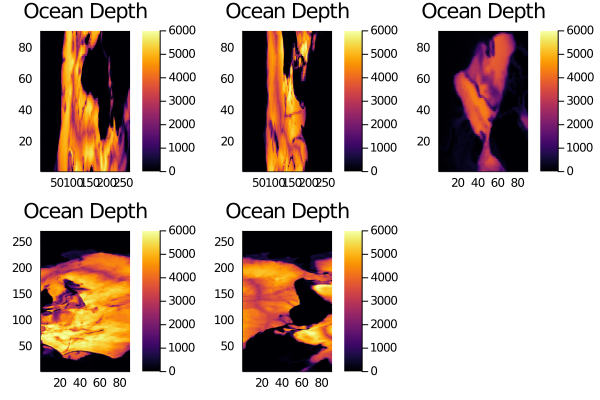

In [3]:
p=dirname(pathof(MeshArrays))
include(joinpath(p,"../examples/Plots.jl"))
heatmap(D,title="Ocean Depth",clims=(0.,6000.))

## `MeshArray` Behaves Like `Array`

Here are a few examples that would be coded similarly in both cases

In [4]:
size(D)
eltype(D)
view(D,:)

D .* 1.0
D .* D
1000*D
D*1000

D[findall(D .> 300.)] .= NaN
D[findall(D .< 1.)] .= NaN

D[1]=0.0 .+ D[1]
tmp=cos.(D);

## Try Another Grid

The `cube-sphere` grid in `MeshArrays.GRID_CS32` has 6 subdomains, each of size `32x32`.

In [5]:
pth=MeshArrays.GRID_CS32
γ=GridSpec("CubeSphere",pth)
D=γ.read(γ.path*"Depth.data",MeshArray(γ,Float32))
show(D)

  data type   = Float32
  cell pos.   = [0.5, 0.5, 0.5]
  tile array  = (6,)
  tile sizes  = (32, 32)
                (32, 32)
                (32, 32)
                (32, 32)
                (32, 32)
                (32, 32)
  grid class  = CubeSphere
  MeshArray   = gcmarray 
  version     = 0.2.14 


## The `exchange` Function

This function adds neighboring data points (columns or rows) at face edges to slightly extend the computational domain. Doing this is often needed e.g. to compute partial derivatives between subdomains of the climate system.

In [6]:
Dexch=exchange(D,4)
show(Dexch)

  data type   = Float32
  cell pos.   = [0.5, 0.5, 0.5]
  tile array  = (6,)
  tile sizes  = (40, 40)
                (40, 40)
                (40, 40)
                (40, 40)
                (40, 40)
                (40, 40)
  grid class  = CubeSphere
  MeshArray   = gcmarray 
  version     = 0.2.14 


Here is a visualization for subdomain `#6`:

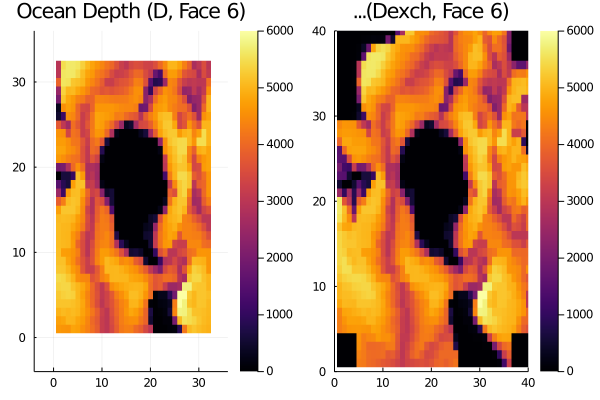

In [7]:
P=heatmap(D.f[6],title="Ocean Depth (D, Face 6)",lims=(-4,36))
Pexch=heatmap(Dexch.f[6],title="...(Dexch, Face 6)",lims=(0,40))
plot(P,Pexch)

# Global Diffusion Example

Regular testing of `MeshArrays.jl` uses the `smooth()` function as an example. Starting from a random noise field, diffusive smoothing efficiency is predictable and can be set via a scale parameter [(see Weaver and Courtier, 2001)](https://doi.org/10.1002/qj.49712757518).

This example also illustrates the generality of the approach chosen in `MeshArrays.jl`, where the same code (see `demo2`) is pretty much readily applicable to any `PeriodicDomain`, `PeriodicChannel`, `CubeSphere`, or `LatLonCap` grid. Here the chosen grid crudely represents the Earth as a unit-cube with `16*16` points on each of the 6 faces. Grid cell areas and distances are all artificially set to `1.0` for simplicity.

In [8]:
p=dirname(pathof(MeshArrays))
include(joinpath(p,"../examples/Demos.jl"))
γ,Γ=GridOfOnes("CubeSphere",6,16)
Δ=demo2(Γ);

The initial noise field is `D[1]` while the smoothed one is `D[2]`. After `smooth()` has been applied via `demo2()`, the noise field is visibly smoother and more muted.

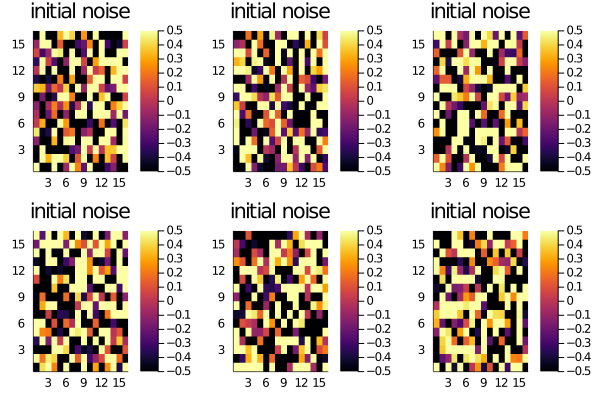

In [9]:
heatmap(Δ[1],title="initial noise",clims=(-0.5,0.5))

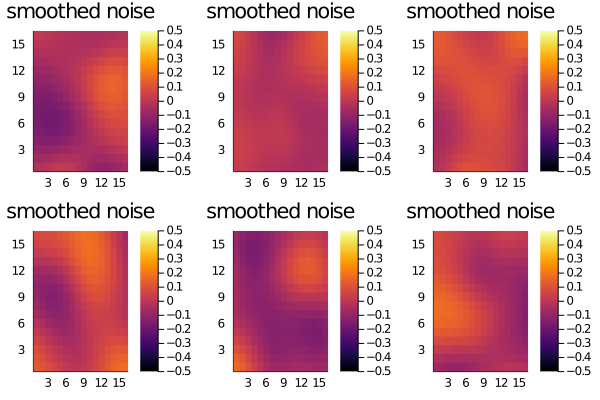

In [10]:
heatmap(Δ[2],title="smoothed noise",clims=(-0.5,0.5))

The computational cost of `smooth()` predictably  increases with the decorrelation scale. For more about how this works, please refer to **Weaver and Courtier, 2001** _Correlation modelling on the sphere using a generalized diffusion equation_ https://doi.org/10.1002/qj.49712757518

In [11]:
Rini=Δ[1]
DXCsm=Δ[3]
DYCsm=Δ[4]
@time Rend=smooth(Rini,DXCsm,DYCsm,Γ);
@time Rend=smooth(Rini,2DXCsm,2DYCsm,Γ);

  0.001692 seconds (7.74 k allocations: 6.856 MiB)
  0.013826 seconds (28.66 k allocations: 24.473 MiB)
